# INFORMAÇÕES IMPORTANTES:

## Dependências

## Especificações da Pesquisa

- Horizonte de previsão: 30 min, 1 hora, 3 horas


# Utilização de rede neural recorrente LSTM para previsões intradiárias do mercado de ações. 

## Base de Dados:

In [1]:
import pandas as pd
import tensorflow as tf
#-----------------------------------------------------------
# Base de dados de 2019(antes da pandemia) e Base da ação de 2021(durante a pandemia)
# BPAC11, (BTG PACTUAL), ITUB4 (ITAÚ), BBDC4 (BRADESCO)
#-----------------------------------------------------------



#-----------------------------------------------------------
#Lendo o arquivo em csv
#-----------------------------------------------------------
df = pd.read_csv('/home/bene/MachineLearning/TCC/Base de Dados/BPAC_30m_2019.csv') 
#df = pd.read_csv('/home/bene/MachineLearning/TCC/Base de Dados/dados_teste.csv') 
df.head()

#print(df)
#df.info()

,time,open,high,low,close,Volume
0,2019-01-02T10:00:00-02:00,5.9125,5.9375,5.9125,5.9300,7600
1,2019-01-02T10:30:00-02:00,5.9300,5.9700,5.9200,5.9525,46800
2,2019-01-02T11:00:00-02:00,5.9575,5.9925,5.9400,5.9800,52800
3,2019-01-02T11:30:00-02:00,5.9875,6.0050,5.9825,5.9900,57200
4,2019-01-02T12:00:00-02:00,5.9950,6.0350,5.9900,6.0175,60400


In [2]:
#-----------------------------------------------------------
#Para mudar o index, utilizei a fonte abaixo
# Fonte: https://www.delftstack.com/pt/howto/python-pandas/pandas-remove-index/#remover-%25C3%25ADndice-de-um-pandas-dataframe-utilizando-o-m%25C3%25A9todo-set_index
#-----------------------------------------------------------

df = df.set_index('time') #Mudando o index para o date
#print(df.index)

#-----------------------------------------------------------
#Sabe se mudou o index, porque com o df.info, ele não aparece como um dos parametros
#-----------------------------------------------------------
df.info()

#print(df)


<class 'pandas.core.frame.DataFrame'>
Index: 3917 entries, 2019-01-02T10:00:00-02:00 to 2019-12-30T17:30:00-03:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    3917 non-null   float64
 1   high    3917 non-null   float64
 2   low     3917 non-null   float64
 3   close   3917 non-null   float64
 4   Volume  3917 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 183.6+ KB


## Gráficos:

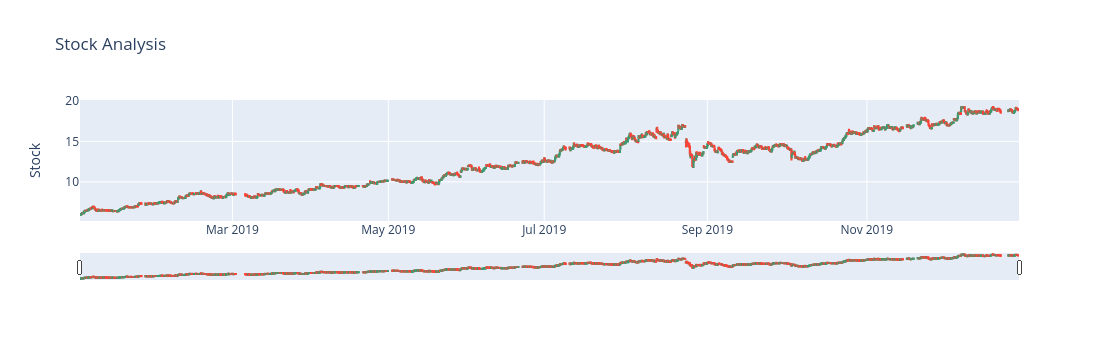

In [4]:
#-----------------------------------------------------------
#Transformando os dados em candlestick para melhorar a vizualização
#Fonte: https://python.plainenglish.io/a-simple-guide-to-plotly-for-plotting-financial-chart-54986c996682
#-----------------------------------------------------------

'''TENTAR COM UMA BASE MENOR '''
''' Talvez tenha ficado dessa maneira por ter muitos dados'''
import plotly.graph_objects as go
fig = go.Figure(go.Candlestick(x=df.index,
  open=df['open'],
  high=df['high'],
  low=df['low'],
  close=df['close']))


fig.update_xaxes(
        rangeslider_visible=True,
        rangebreaks=[
            # NOTE: Below values are bound (not single values), ie. hide x to y
            dict(bounds=["sat", "mon"]),  # hide weekends, eg. hide sat to before mon
            dict(bounds=[15.5, 10], pattern="hour"),  # hide hours outside of 9.30am-4pm
            # dict(values=["2019-12-25", "2020-12-24"])  # hide holidays (Christmas and New Year's, etc)
        ]
)

fig.update_layout(
        title='Stock Analysis',
        yaxis_title='Stock'
)

fig.show()

#https://stackoverflow.com/questions/63780293/python-plotly-how-to-remove-datetime-gaps-in-candle-stick-chart
#https://plotly.com/python/ohlc-charts/

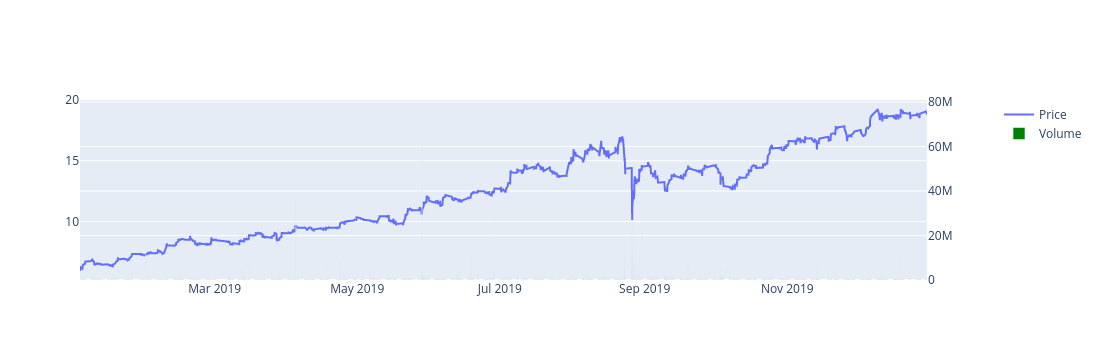

In [5]:
#-----------------------------------------------------------
# Gráfico de linha, na B3 contem  somente os preços de fechamento
# Fonte: https://pythoninoffice.com/draw-stock-chart-with-python/
#-----------------------------------------------------------

import plotly.graph_objects as go

#-----------------------------------------------------------
# Somente linhas
#-----------------------------------------------------------
#fig = go.Figure(data=go.Scatter(x=df.index,y=df['close'], mode='lines'))
#fig.show()

#-----------------------------------------------------------
# Somente linhas e pontos
#-----------------------------------------------------------
#fig = go.Figure(data=go.Scatter(x=df.index,y=df['close'], mode='lines+markers'))
#fig.show()


from plotly.subplots import make_subplots
#-----------------------------------------------------------
# Neste momento, as barras de volume têm todas a mesma cor. 
#Podemos usar cores diferentes para distinguir entre um dia de alta ou de 
#baixa – verde para dias de alta e vermelho para dias de baixa.
#Para fazer isso, basta calcular a mudança diária (positiva ou negativa) 
#e inserir uma coluna de cores em nosso dataframe
#-----------------------------------------------------------
df['diff'] = df['close'] - df['open']
df.loc[df['diff']>=0, 'color'] = 'green'
df.loc[df['diff']<0, 'color'] = 'red'

fig = make_subplots(specs=[[{"secondary_y": True}]])

#-----------------------------------------------------------
# Apesar do preço de fechamento do ativo ser o item mais avaliado, 
# o gráfico de linhas também permite visualizar valores de abertura, 
# mínimas ou máximas de forma separada.
#-----------------------------------------------------------

#-----------------------------------------------------------
# O gráfico de linhas
#-----------------------------------------------------------
fig.add_trace(go.Scatter(x=df.index,y=df['close'],name='Price'),secondary_y=False)

#-----------------------------------------------------------
# O gráfico de barras
#-----------------------------------------------------------
fig.add_trace(go.Bar(x=df.index,y=df['Volume'],name='Volume', marker={'color':df['color']}),secondary_y=True)
fig.show()


## Pré-processamento de dados:

In [6]:
#-----------------------------------------------------------
#1º Passo: Retirar valores nulos
#-----------------------------------------------------------

'''Valores nulos podem ser só considerados valores NaN ou valor 0?
Um valor 0 poderia causar problema para a previsão? '''
# https://insightlab.ufc.br/6-truques-do-pandas-para-impulsionar-sua-analise-de-dados
#Quando o conjunto de dados é grande, podemos contar o número de valores ausentes.
df.isnull().sum()
#print(df)

#https://medium.com/codex/simple-moving-average-and-exponentially-weighted-moving-average-with-pandas-57d4a457d363
#https://www.statology.org/exponential-moving-average-pandas/
#https://towardsdatascience.com/time-series-from-scratch-exponentially-weighted-moving-averages-ewma-theory-and-implementation-607661d574fe



open      0
high      0
low       0
close     0
Volume    0
diff      0
color     0
dtype: int64

## Normalização

In [9]:
#-----------------------------------------------------------
# 2º Passo: Normalização da base (valores ruidosos) 
# Utilização do Log_return para preços de fechamento da ação
#-----------------------------------------------------------
import numpy as np
import pandas as pd


data = pd.DataFrame(df['close'])
#-----------------------------------------------------------
# Os retornos de log são calculados de forma vetorizada (“sem loop” no nível do Python).
#-----------------------------------------------------------
data['returns'] = np.log(data / data.shift(1))
print(data['returns'])


#-----------------------------------------------------------
# Verificar quantos valores ausentes existem
#-----------------------------------------------------------
data.isnull().sum()

#-----------------------------------------------------------
# Um subconjunto dos dados é selecionado e os valores NaN (“não é um número”) são eliminados.
#-----------------------------------------------------------
data.dropna(inplace=True)





time
2019-01-02T10:00:00-02:00         NaN
2019-01-02T10:30:00-02:00    0.003787
2019-01-02T11:00:00-02:00    0.004609
2019-01-02T11:30:00-02:00    0.001671
2019-01-02T12:00:00-02:00    0.004580
                               ...   
2019-12-30T15:30:00-03:00    0.002649
2019-12-30T16:00:00-03:00    0.000132
2019-12-30T16:30:00-03:00    0.001850
2019-12-30T17:00:00-03:00   -0.000925
2019-12-30T17:30:00-03:00   -0.006098
Name: returns, Length: 3917, dtype: float64


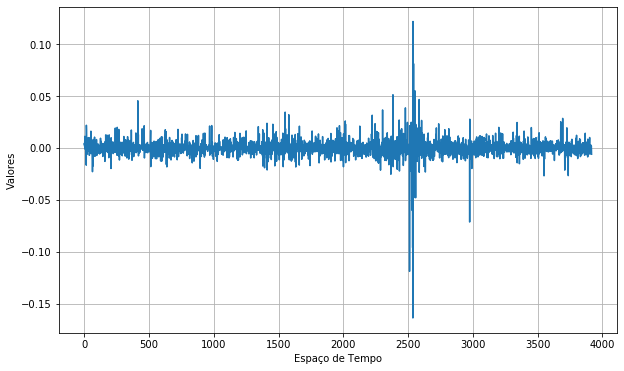

In [8]:
import numpy as np
import matplotlib.pyplot as plt


#-----------------------------------------------------------
# Construo um gráfico com os valores de Log_retorno e o Tempo de 0->3915 (Que seria o número de valores)
# existentes na base.
#-----------------------------------------------------------
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Espaço de Tempo")
    plt.ylabel("Valores")
    plt.grid(True)

time_step = []
log_return = []
number = 0

for row in data['returns']:
    log_return.append(float(row))
    number+=1
    time_step.append(int(number))


series = np.array(log_return)
time = np.array(time_step)

plt.figure(figsize=(10, 6))
plot_series(time, series)

## Discretização

In [11]:
#-----------------------------------------------------------
# Discretização dos dados
# Classe 1 correspondendo ao movimento de subida na série de retornos, 
# e classe 0 correspondendo ao movimento de queda. A classe 1 é atribuída
# a todos os valores da série maiores ou iguais a zero, e a classe 0 é atribuída
# aos valores menores que zero.
#-----------------------------------------------------------

#-----------------------------------------------------------
# NP.SIGN: implementação passo-a-passo 
# Explicação: The sign function returns -1 if x < 0, 0 if x==0, 1 if x > 0. nan is returned for nan inputs.
# Fonte: https://stackoverflow.com/questions/39650312/convert-a-numpy-array-into-an-array-of-signs-with-0-as-positive
#
#data['direction'] = np.sign(2*(0.003787 >= 0)).astype(int)
#data['direction'] = np.sign(2*(True)).astype(int)
#data['direction'] = np.sign(2*(1)).astype(int)
#
# Tem dois valores possiveis que podem sair: 0, ou 2, que seria o valor de x.
# Se x > 0 , ou seja, x = 2, então a saida= 1.
# Se x == 0, ou seja, x = 0, então a saida= 0.
#-----------------------------------------------------------

data['direction'] = np.sign(2*(data['returns'] >= 0)).astype(int)
display(data)

#data.head()



#-----------------------------------------------------------
# Plotar o gráfico
#-----------------------------------------------------------
#rets.plot(subplots=True, figsize=(10, 6));

,close,returns,direction
time,,,
2019-01-02T10:30:00-02:00,5.9525,0.003787,1
2019-01-02T11:00:00-02:00,5.9800,0.004609,1
2019-01-02T11:30:00-02:00,5.9900,0.001671,1
2019-01-02T12:00:00-02:00,6.0175,0.004580,1
2019-01-02T12:30:00-02:00,6.0850,0.011155,1
...,...,...,...
2019-12-30T15:30:00-03:00,18.8975,0.002649,1
2019-12-30T16:00:00-03:00,18.9000,0.000132,1
2019-12-30T16:30:00-03:00,18.9350,0.001850,1


In [12]:
import numpy as np
import matplotlib.pyplot as plt

time = []
direction = []
number = 0

for row in data['direction']:
    direction.append(int(row))
    number+=1
    time.append(int(number))


series = np.array(log_return)
time = np.array(time_step)


## Separação em conjunto de treinamento e teste

Em seguida, você dividirá os dados acima em conjuntos de treinamento e validação. Você receberá os primeiros 1.000 pontos para treinamento, enquanto o restante é para validação.

In [42]:
#-----------------------------------------------------------
# Definir a separação entre conjunto de Treinamento e de Teste
#-----------------------------------------------------------
# Total = 3916 (len(rets))
# Treinamento = 2740
# Teste = 1176

split_time = 2740
time_train = time[:split_time]
x_train = series[:split_time]
print(x_train)

time_test = time[split_time:]
x_test = series[split_time:]
print(x_test)

[1 1 1 ... 1 1 0]
[0 1 0 ... 1 0 0]


## Preparar recursos/features/entradas e os rótulos/labels/saida

### Preparar o Dataset(Dados de Log_return) todo

In [54]:
#-----------------------------------------------------------
# Transformar o Dataset em uma lista
#-----------------------------------------------------------
dataset = data['direction'].values.tolist()
#print(dataset)


#-----------------------------------------------------------
# Com a ajuda de tf.data.Dataset.from_tensor_slices()method, podemos obter as 
# fatias de um array na forma de objetos usando tf.data.Dataset.from_tensor_slices()method.
# https://acervolima.com/tensorflow-tf-data-dataset-from_tensor_slices/
#-----------------------------------------------------------
dataset = tf.data.Dataset.from_tensor_slices(dataset)
#print(dataset)

#-----------------------------------------------------------
# Janela os dados, mas apenas pegue aqueles com o tamanho especificado. No exemplo abaixo,
# separa os dados de 5 em 5:
# [0.0037870863, 0.0046092686, 0.0016708442, 0.0045804786, 0.011154836] 
# Obs: O drop_remainder=True deixa os dados regularmente dimensionados. Mas o que isso quer dizer?
# Quer dizer que temos uma dimensão dessa maneira:
# 0 1 2 3 4 5
# 1 2 3 4 5 6
# 2 3 4 5 6 7
# ao invés de:
# 0 1 2 3 4 5
# 1 2 3 4 
# 1 2 
#-----------------------------------------------------------
dataset = dataset.window(size=5, shift=1, drop_remainder=True)

#-----------------------------------------------------------
# Printa na tela o janelamento anterior
#-----------------------------------------------------------
#for window_dataset in dataset:
  #print([item.numpy() for item in window_dataset])

    
#-----------------------------------------------------------
# Achate as janelas colocando seus elementos em um único lote:
# Exemplo: [0.00378709 0.00460927 0.00167084 0.00458048 0.01115484]
#-----------------------------------------------------------
dataset = dataset.flat_map(lambda window: window.batch(5))

#-----------------------------------------------------------
# Printa na tela o achatamento anterior
#-----------------------------------------------------------
#for window in dataset:
  #print(window.numpy())


#-----------------------------------------------------------
# Cria tuplas com recursos/features (os quatro primeiros elementos da janela) e rótulos/labels (último elemento)
#-----------------------------------------------------------
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

#-----------------------------------------------------------
# Printa na tela os recursos/features/entradas e os rótulos/labels/saida
#-----------------------------------------------------------
#for x,y in dataset:
#    print(x.numpy(), y.numpy())

    
#-----------------------------------------------------------
# Emabaralha os valores para não criar um vies (NÃO ACHO NECESSÁRIO POR ENQUANTO)
#-----------------------------------------------------------
#dataset = dataset.shuffle(buffer_size=10)


#-----------------------------------------------------------
# Cria lotes de janelas, ou seja, se definimos:
# dataset = dataset.batch(batch_size).prefetch(1)
# Onde batch_size = 2, quer dizer que será de blocos de 2 em 2, exemplo:
# x =  [[0.00378709 0.00460927 0.00167084 0.00458048] (entrada 1)
#      [0.00460927 0.00167084 0.00458048 0.01115484]] (entrada 2)
# y =  [[0.01115484] (saida 1)
#      [0.0094051 ]] (saida 2)
# Um maior batch_size reduz seu tempo computacional
#-----------------------------------------------------------
dataset = dataset.batch(2).prefetch(1)

#-----------------------------------------------------------
# Printa na tela a configuração dos batches
#-----------------------------------------------------------
#for x,y in dataset:
   # print("x = ", x.numpy())
   # print("y = ", y.numpy())


### Preparar os dados de Treinamento

In [48]:
#-----------------------------------------------------------
# Parametros a serem usados na função de conjunto de dados janelado
#
# WINDOW_SIZE(int): Janela os dados, mas apenas pegue aqueles com o tamanho especificado.No exemplo abaixo,
# separa os dados de 4 em 4.
# BATCH_SIZE(int): Cria lotes de janelas, ou seja, se definimos batch_size = 2, quer dizer que será 
# de blocos de 2 em 2.
# Obs: O batch_size costuma ser: 32, 64, 128 (https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/)
# SHUFFLE_BUFFER_SIZE(int): Emabaralha os valores para não criar um vies (NÃO ACHO NECESSÁRIO POR ENQUANTO)
#-----------------------------------------------------------

window_size = 4
batch_size = 32
#shuffle_buffer_size = 1000

def windowed_dataset(series, window_size, batch_size):
#def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Gera janelas de conjunto de dados

    Args:
      series (array of float) - Contém os valores da série temporal de treinamento
      window_size (int) - o número de passos de tempo para a média
      batch_size (int) - o tamanho do lote
      shuffle_buffer(int) - tamanho do buffer a ser usado para o método shuffle

    Returns:
      dataset (TF Dataset) - Conjunto de dados de treinamento contendo janelas de tempo
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Embaralhe as janelas
    #dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

#-----------------------------------------------------------
# Gera o conjunto de dados de TREINAMENTO já com as dimensões previamente especificadas na função
#-----------------------------------------------------------
train_set = windowed_dataset(x_train, window_size, batch_size)
#train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

#-----------------------------------------------------------
# Printa na tela a configuração  de todas as dimensões pré-definidas
#-----------------------------------------------------------
#for x,y in train_set:
#    print("x = ", x.numpy())
#    print("y = ", y.numpy())

https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W4/ungraded_labs/C4_W4_Lab_1_LSTM.ipynb

https://colab.research.google.com/github/BeneInfosec/MachineLearning/blob/main/Coursera_Sequences_Time%20_Series_and_Prediction/Semana_4_Licao_2_Sunspots.ipynb

https://sailajakarra.medium.com/lstm-for-time-series-predictions-cc68cc11ce4f
https://medium.com/keita-starts-data-science/time-series-split-with-scikit-learn-74f5be38489e 
https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/
https://machinelearningmastery.com/use-timesteps-lstm-networks-time-series-forecasting/
https://humboldt-wi.github.io/blog/research/information_systems_1718/06financialtime-series/

## Construindo a Rede neural artificial

### Long short-term memory (LSTM)

In [72]:

#-----------------------------------------------------------
# Limpa todas as variváveis internas
#-----------------------------------------------------------
tf.keras.backend.clear_session()

#-----------------------------------------------------------
# Construindo o modelo
#
#   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[window_size]):
#A primeira camada Lambda será usado para nos ajudar com nossa dimensionalidade. Usando o Lambda, 
#nós apenas expandimos a matriz em 1 dimensão. Ao definir a forma de entrada para nenhum, estamos 
#dizendo que o modelo pode levar sequências de qualquer comprimento.
#
#   tf.keras.layers.Lambda(lambda x: x * 400)
# Se aumentarmos as saídas em 100, podemos ajudar no treinamento (NÃO ENTENDI)
#
#
#-----------------------------------------------------------
model = tf.keras.models.Sequential([

  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

#-----------------------------------------------------------
# Printar na tela as configurações do Modelo
#-----------------------------------------------------------
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4, 64)             256       
_________________________________________________________________
lstm (LSTM)                  (None, 4, 64)             33024     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0         
Total params: 66,369
Trainable params: 66,369
Non-trainable params: 0
_________________________________________________________________


### Ajustando a taxa de aprendizagem

In [83]:
# Get initial weights (TENDI NÃO)
#init_weights = model.get_weights()


#-----------------------------------------------------------
# Ajuste da taxa de aprendizagem: Cada época muda a taxa de aprendizagem
#-----------------------------------------------------------
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

#-----------------------------------------------------------
# Ajustando a taxa de aprendizagem
#-----------------------------------------------------------
optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)

#-----------------------------------------------------------
#Usando perda de Huber como sua função de perda para minimizar a 
#sensibilidade a valores discrepantes.
#-----------------------------------------------------------
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer)

#-----------------------------------------------------------
#Treinar por 100 epocas e ver a taxa de aprendizagem
# Obs: Callback para ajustar a taxa de aprendizagem.
#-----------------------------------------------------------
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule]) 



Epoch 1/100
86/86 [==============================] - 4s 8ms/step - loss: 0.1295
Epoch 2/100
86/86 [==============================] - 1s 8ms/step - loss: 0.1244
Epoch 3/100
86/86 [==============================] - 1s 9ms/step - loss: 0.1241
Epoch 4/100
86/86 [==============================] - 1s 8ms/step - loss: 0.1241
Epoch 5/100
86/86 [==============================] - 1s 8ms/step - loss: 0.1241
Epoch 6/100
86/86 [==============================] - 1s 7ms/step - loss: 0.1241
Epoch 7/100
86/86 [==============================] - 1s 7ms/step - loss: 0.1241
Epoch 8/100
86/86 [==============================] - 1s 7ms/step - loss: 0.1241
Epoch 9/100
86/86 [==============================] - 1s 8ms/step - loss: 0.1241
Epoch 10/100
86/86 [==============================] - 1s 8ms/step - loss: 0.1241
Epoch 11/100
86/86 [==============================] - 1s 7ms/step - loss: 0.1242
Epoch 12/100
86/86 [==============================] - 1s 8ms/step - loss: 0.1242
Epoch 13/100
86/86 [=================

[1e-08, 0.001, 0, 50]

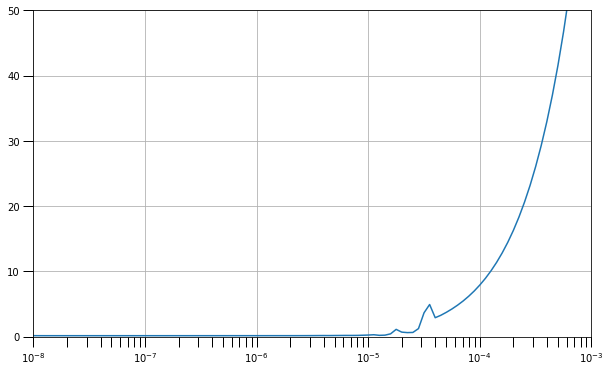

In [84]:
#-----------------------------------------------------------
# Plotar o gráfico para analisar a taxa de aprendizagem e ajustar os valores posteriormente
#-----------------------------------------------------------


#-----------------------------------------------------------
# Forma 1
#-----------------------------------------------------------
#plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-8, 1e-4, 0, 60])

#-----------------------------------------------------------
# Forma 2
#-----------------------------------------------------------


# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])


In [92]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



#-----------------------------------------------------------
# Ajusta o valor do Learning, de acordo com o gráfico anterior e roda tudo de novo
# Ex. 10⁻⁵
#-----------------------------------------------------------

#-----------------------------------------------------------
# Limpa todas as variváveis internas
#-----------------------------------------------------------
tf.keras.backend.clear_session()

# Reset the weights (TENDI NÃO)
#model.set_weights(init_weights)


#-----------------------------------------------------------
# Ajustando a taxa de aprendizagem
#-----------------------------------------------------------
learning_rate = 6e-6

#-----------------------------------------------------------
# Ajustando a taxa de aprendizagem (Setando o Optimizer)
#-----------------------------------------------------------
#optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

#-----------------------------------------------------------
#Usando perda de Huber como sua função de perda para minimizar a 
#sensibilidade a valores discrepantes.
#-----------------------------------------------------------
model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',metrics=['accuracy',f1_m,precision_m, recall_m]) # Mean Absolute Error 

#-----------------------------------------------------------
# Treinando agora com 500 épocas
#-----------------------------------------------------------
history = model.fit(train_set,epochs=100)

Epoch 1/100
86/86 [==============================] - 4s 9ms/step - loss: 17.5036 - accuracy: 0.5164 - f1_m: 0.5546 - precision_m: 0.5480 - recall_m: 0.6363
Epoch 2/100
86/86 [==============================] - 1s 9ms/step - loss: 0.4484 - accuracy: 0.5121 - f1_m: 0.4250 - precision_m: 0.4806 - recall_m: 0.5159
Epoch 3/100
86/86 [==============================] - 1s 8ms/step - loss: 0.2784 - accuracy: 0.4963 - f1_m: 0.3889 - precision_m: 0.4071 - recall_m: 0.5075
Epoch 4/100
86/86 [==============================] - 1s 8ms/step - loss: 0.2553 - accuracy: 0.5088 - f1_m: 0.3912 - precision_m: 0.3853 - recall_m: 0.5092
Epoch 5/100
86/86 [==============================] - 1s 8ms/step - loss: 0.2454 - accuracy: 0.5044 - f1_m: 0.3829 - precision_m: 0.3705 - recall_m: 0.5004
Epoch 6/100
86/86 [==============================] - 1s 8ms/step - loss: 0.2478 - accuracy: 0.5069 - f1_m: 0.3762 - precision_m: 0.3518 - recall_m: 0.5043
Epoch 7/100
86/86 [==============================] - 1s 8ms/step - lo

https://colab.research.google.com/github/BeneInfosec/MachineLearning/blob/main/Coursera_Sequences_Time%20_Series_and_Prediction/Semana_4_Licao_2_Sunspots.ipynb#scrollTo=vVcKmg7Q_7rD

https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W2/ungraded_labs/C4_W2_Lab_3_deep_NN.ipynb#scrollTo=zqVlvuneFqJz

https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W3/ungraded_labs/C4_W3_Lab_1_RNN.ipynb

https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W4/ungraded_labs/C4_W4_Lab_1_LSTM.ipynb


LSTM (Discretização +1 e -1) (classificação)
Entender os parametros (LSTM)
Utilizar o dados de Teste